# Setup


### Libraries
I will be using the following libraries to build my model
- **imbalanced-learn:** Since the data is imbalanced, I will use SMOT resmpling from this library to balance my dataset
- **contractions:** To convert contracted words like 'I've' or 'It's' to their expanded versions

### Data parsing

To make it easier to read into a dataframe, I have used a few sed commands to convert the txt file into a csv format.

In [ ]:
# %%capture
!pip install numpy pandas imbalanced-learn nltk contractions
!python -m textblob.download_corpora
!python -m spacy download en_core_web_sm
!rm -rf ./data/
!mkdir -p ./data/
!wget -c -O ./data/finefoods.txt "https://raw.githubusercontent.com/mss423/data602-fall2022/main/Assignment%204/finefoods_training.txt"


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("C

In [ ]:
!cat ./data/finefoods.txt \
  | sed -z 's/\n/{COLSEPARATOR{/g' \
  | sed -z 's/{COLSEPARATOR{{COLSEPARATOR{/{\n/g' \
  | sed -z 's/COLSEPARATOR/,/g' \
  | sed -z 's/product\/productId\: /{/g' \
  | sed -z 's/review\/userId\: //g' \
  | sed -z 's/review\/profileName\: //g' \
  | sed -z 's/review\/helpfulness\: //g' \
  | sed -z 's/review\/score\: //g' \
  | sed -z 's/review\/time\: //g' \
  | sed -z 's/review\/summary\: //g' \
  | sed -z 's/review\/text\: //g' > ./data/finefoods.csv


In [ ]:
! head -n 10 ./data/finefoods.csv

{B001E4KFG0{,{A3SGXH7AUHU8GW{,{delmartian{,{1/1{,{5.0{,{1303862400{,{Good Quality Dog Food{,{I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.{
{B00813GRG4{,{A1D87F6ZCVE5NK{,{dll pa{,{0/0{,{1.0{,{1346976000{,{Not as Advertised{,{Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".{
{B000LQOCH0{,{ABXLMWJIXXAIN{,{Natalia Corres "Natalia Corres"{,{1/1{,{4.0{,{1219017600{,{"Delight" says it all{,{This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  N

# Analysis

Looking at the dataset, especially the text columns, I found that the data is not clean (as it is a user input).
Some had html in them, some had expanded/contracted words, special characters and so on. So it was necessary to clean the data before vectorizing the text.

Here are some preprocessing that I did to clean the data:

1. **Removed html**
Some reviews and summaries had html tags in them. Since they don't add meaning to the review itself, I removed them by parsing with lxml library and getting the text version of the parsed html.

2. **Expanded word contractions**:
Before vectorizing the words, I converted the contracted words like 'I've', 'it's', 'you've' into their full form using the contractions library.

3. **Converted all text to lowercase**: 
To make same words be counted in the same vector regardless of their case, I converted all the text to lowercase.

4. **Others**: 
Stripped punctuations, removed special characters

In [ ]:
import pandas as pd 
import numpy as np 

headers = ["productId", "userId", "profileName", "helpfulness", "score", "time", "summary", "text"]

df = pd.read_csv("./data/finefoods.csv", encoding='latin-1', names=headers, quotechar='{', quoting=1)
df.head()

,productId,userId,profileName,helpfulness,score,time,summary,text
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1/1,5.0,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0/0,1.0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1/1,4.0,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,B000UA0QIQ,A395BORC6FGVXV,Karl,3/3,2.0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0/0,5.0,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
def get_helpful_count(row):
  helpfulness_score = row["helpfulness"]
  return int(helpfulness_score.split("/")[0])

def get_unhelpful_count(row):
  helpfulness_score = row["helpfulness"]
  helpful, total = list(map(lambda x: int(x), helpfulness_score.split("/")))
  return total - helpful

df["helpful_count"] = df.apply(get_helpful_count, axis=1)
df["unhelpful_count"] = df.apply(get_unhelpful_count, axis=1)

df[["helpfulness", "helpful_count", "unhelpful_count"]].head(20)
df.drop(["helpfulness"], axis=1, inplace=True)
df.head(9)

,productId,userId,profileName,score,time,summary,text,helpful_count,unhelpful_count
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,5.0,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1,0
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,1.0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0,0
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",4.0,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1,0
3,B000UA0QIQ,A395BORC6FGVXV,Karl,2.0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,3,0
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",5.0,1350777600,Great taffy,Great taffy at a great price. There was a wid...,0,0
5,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,4.0,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...,0,0
6,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,5.0,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...,0,0
7,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,5.0,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...,0,0
8,B000E7L2R4,A1MZYO9TZK0BBI,R. James,5.0,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...,1,0


In [ ]:
from lxml.html import fromstring
pattern = '<[^<]+?>'
def remove_html(colname):
  def mapper(row):
    value = row[colname]
    parser = fromstring(value)
    outputString = str(parser.text_content())
    return outputString
  return mapper

df["profileName"] = df.apply(remove_html("profileName"), axis=1)
df["summary"] = df.apply(remove_html("summary"), axis=1)
df["text"] = df.apply(remove_html("text"), axis=1)
df["body"] = df["summary"] + " " + df["text"]

In [ ]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer,ToktokTokenizer
import re 
import contractions
from string import punctuation
from sklearn.model_selection import train_test_split

nltk.download('stopwords')
nltk.download('omw-1.4')


X = df.body
y = df.score

def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

def strip_punctuation(s):
    return ''.join(c for c in s if c not in punctuation)

def to_lower(text):
    return ' '.join([w.lower() for w in word_tokenize(text)])

def remove_stopwords(text):
    words = [w for w in text if w not in stopword_list]
    return words

from nltk.corpus import wordnet

def replaceElongated(word):
    repeat_regexp = re.compile(r'(\w*)(\w)\2(\w*)')
    repl = r'\1\2\3'
    if wordnet.synsets(word):
        return word
    repl_word = repeat_regexp.sub(repl, word)
    if repl_word != word:      
        return replaceElongated(repl_word)
    else:       
        return repl_word


stopword_list=nltk.corpus.stopwords.words('english')

X = X.apply(lambda x: contractions.fix(x))
X = X.apply(to_lower)
X = X.apply(remove_special_characters)
X = X.apply(strip_punctuation)
X = X.apply(replaceElongated)

tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
X = X.apply(lambda x: tokenizer.tokenize(x))
X = X.apply(lambda x: remove_stopwords(x))

X

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


0       [god, quality, dog, fod, bought, several, vita...
1       [advertised, product, arived, labeled, jumbo, ...
2       [delight, says, al, confection, ben, around, c...
3       [cough, medicine, loking, secret, ingredient, ...
4       [great, tafy, great, tafy, great, price, wide,...
                              ...                        
1995    [great, wafles, us, noncoks, laugh, reviews, s...
1996    [excelent, flufy, pancakes, read, favorable, r...
1997    [god, basic, mix, expecting, great, things, ba...
1998    [god, pancakes, lots, work, love, pancake, mix...
1999    [wafles, schmafles, say, wonderful, highlight,...
Name: body, Length: 2000, dtype: object

In [ ]:
from nltk.stem import SnowballStemmer

snowball_stemmer = SnowballStemmer('english')

def stem_update(text_list):
    return [snowball_stemmer.stem(word) for word in text_list]
    for word in text_list:
        word = snowball_stemmer.stem(word)
        text_list_new.append(word)
    return text_list_new
X = X.apply(stem_update)
X = X.apply(lambda x: " ".join(x))
X

0       god qualiti dog fod bought sever vital cane do...
1       adverti product ariv label jumbo salt peanut p...
2       delight say al confect ben around centuri ligh...
3       cough medicin loke secret ingredi robitusin be...
4       great tafi great tafi great price wide asort y...
                              ...                        
1995    great wafl us noncok laugh review said much wo...
1996    excel flufi pancak read favor review pancak mi...
1997    god basic mix expect great thing base review g...
1998    god pancak lot work love pancak mix bought fir...
1999    wafl schmafl say wonder highlight wekend oh us...
Name: body, Length: 2000, dtype: object

In [ ]:
df = pd.concat([X,y],axis=1)
df

,body,score
0,god qualiti dog fod bought sever vital cane do...,5.0
1,adverti product ariv label jumbo salt peanut p...,1.0
2,delight say al confect ben around centuri ligh...,4.0
3,cough medicin loke secret ingredi robitusin be...,2.0
4,great tafi great tafi great price wide asort y...,5.0
...,...,...
1995,great wafl us noncok laugh review said much wo...,5.0
1996,excel flufi pancak read favor review pancak mi...,5.0
1997,god basic mix expect great thing base review g...,4.0
1998,god pancak lot work love pancak mix bought fir...,4.0


# Feature Extraction / Prediction

After preprocessing the raw text and summary data, I converted the text bodies into count vectors and trained a Multinomial Naive Bayes classifier on it.



In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import SMOTE

cv = CountVectorizer()

train_data, test_data = train_test_split(df, train_size=0.8,random_state=0)

X_train = cv.fit_transform(train_data['body'])
y_train = train_data['score']
X_test = cv.transform(test_data['body'])
y_test = test_data['score']

sm = SMOTE()
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
unique, counts = np.unique(y_train_res, return_counts=True)
print(list(zip(unique, counts)))

[(1.0, 1042), (2.0, 1042), (3.0, 1042), (4.0, 1042), (5.0, 1042)]


In [ ]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train_res, y_train_res)

y_pred = nb.predict(X_test)
y_pred

array([4., 1., 5., 5., 5., 1., 3., 5., 5., 5., 5., 5., 4., 4., 5., 5., 5.,
       4., 5., 5., 5., 1., 5., 5., 4., 5., 5., 4., 5., 5., 5., 4., 5., 5.,
       1., 5., 5., 5., 5., 5., 5., 5., 5., 5., 4., 3., 5., 5., 5., 5., 4.,
       5., 1., 5., 5., 5., 5., 5., 5., 5., 4., 5., 4., 5., 1., 5., 5., 5.,
       5., 2., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 3., 5.,
       5., 4., 5., 4., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 1., 5., 5.,
       2., 5., 4., 4., 5., 5., 5., 1., 5., 5., 5., 5., 5., 5., 2., 5., 5.,
       5., 5., 4., 2., 5., 5., 1., 1., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 1., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 2., 5., 4.,
       5., 5., 5., 1., 5., 5., 1., 5., 2., 3., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 4., 5., 5., 5., 5., 5., 5., 5., 5., 4., 5., 5., 5.,
       5., 5., 4., 5., 4., 3., 4., 5., 5., 1., 5., 5., 5., 5., 5., 2., 5.,
       3., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 1.,
       4., 4., 5., 5., 5.

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 65.00%

Confusion Matrix:
 [[ 13   4   0   4   9]
 [  4   2   1   5   9]
 [  2   2   6   3  24]
 [  0   0   4  10  37]
 [  4   3   3  22 229]]


/usr/local/lib/python3.8/dist-packages/numpy/lib/arraysetops.py:608: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


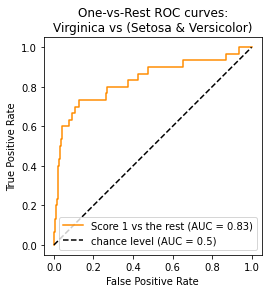

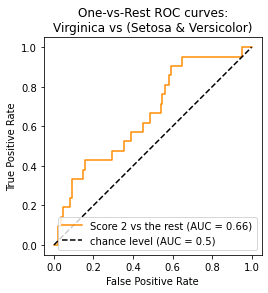

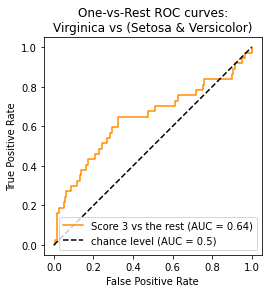

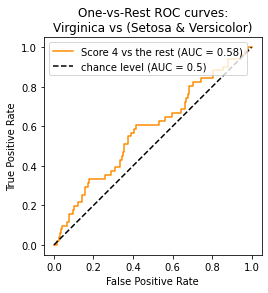

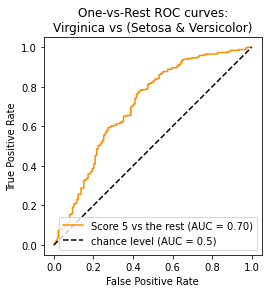

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
label_binarizer.transform(["virginica"])

for class_id in range(5):
  RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    nb.predict_proba(X_test)[:, class_id],
    name=f"Score {class_id + 1} vs the rest",
    color="darkorange",
)
  plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
  plt.axis("square")
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("One-vs-Rest ROC curves:\nVirginica vs (Setosa & Versicolor)")
  plt.legend()
  plt.show()